In [5]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp


## Data

In [94]:
tikers = ['VTI', 'DBC', 'GLD', 'TLT', 'IEF' ]
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2023, 12, 31)
data = yf.download(tikers, start=start, end=end)['Close']
rets = np.log1p(data.pct_change().dropna())

/var/folders/m9/hllqwqb944vgcr87gbp44qp40000gn/T/ipykernel_6829/3509834145.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tikers, start=start, end=end)['Close']
[*********************100%***********************]  5 of 5 completed


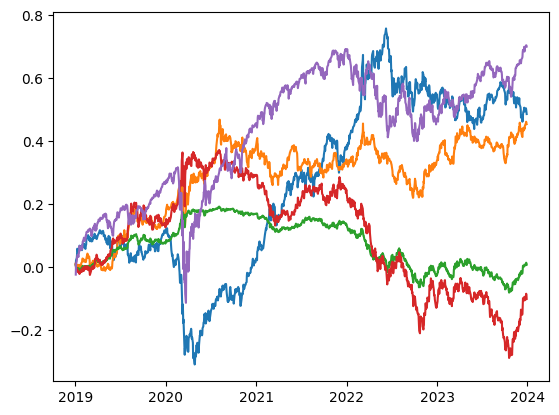

In [95]:
plt.plot(rets.cumsum())

## Objective

$$\min_{w \in \Omega} \; w^T \Sigma w \\
\text{s.t.} \\ 
w \geq 0, \\ 
w^T I = I, \\ 
w^T \mu \geq 0.08$$  

Where, $w\in\mathbb{R}^5$, and $\mu\in\mathbb{R}^5$ such that
$$\mu_i = \frac{252}{T} \sum_{t=1}^T r_{i,t}$$ 
while $\Sigma \in \mathbb{R}^{5 \times 5}$,

$$ \Sigma = \frac{1}{T-1} \mathbb{E}[(R - \mu)(R - \mu)^T]$$ 

### Numerical Solution

In [96]:
np.mean(rets,axis=0)*252

Ticker
DBC    0.097538
GLD    0.091147
IEF    0.001624
TLT   -0.020174
VTI    0.140499
dtype: float64

In [97]:

n = 5
Sigma = rets.cov().values * 252 # Covariance matrix
mu    =  np.mean(rets, axis=0).values * 252  # Annualized mean returns

w = cp.Variable(n)

#Objective function: minimize portfolio variance  (w' Sigma w)
obj = cp.Minimize(cp.quad_form(w, Sigma))

constraints = [
    w >= 0,
    cp.sum(w) == 1,
    mu @ w >= 0.08
]

# ——— Solve ———
prob = cp.Problem(obj, constraints)
result = prob.solve(solver=cp.OSQP)  # OSQP is efficient for QPs

w.value[w.value < 0] = 0  # Ensure no shorting # Ensure no shorting

print("Analytical Results:\n")
print(f"Portfolio return: {float(mu @ w.value):.3f}")
print(f"Portfolio volatility: {float(np.sqrt(w.value.T @ Sigma @ w.value)):.3f}\n")

print("stock allocations:")
for i, tik in enumerate(tikers):
    print(f"{tik}: {w.value[i]*100:.2f}%")

Analytical Results:

Portfolio return: 0.080
Portfolio volatility: 0.098

stock allocations:
VTI: 11.67%
DBC: 33.31%
GLD: 28.12%
TLT: 0.00%
IEF: 26.90%


<BarContainer object of 5 artists>

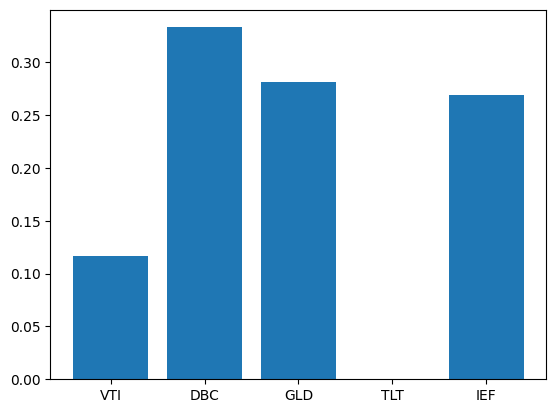

In [98]:
plt.bar(tikers, w.value)

## Simulation

In [99]:
def simulate_portfolio(mu, Sigma, r_star=0.08, n_simulations=5000):
    """
    Simulate portfolio returns based on weights and historical returns.

    Args:
        mu: vector of expected returns
        Sigma: covariance matrix of returns
        r_star: target return for the portfolio

    Returns:
        portfolio_returns: simulated returns of the portfolio
    """
    n_assets = mu.shape[0]
    R_p = np.zeros(n_simulations)
    sigma_p = np.zeros(n_simulations)
    w_p = np.zeros((n_simulations, n_assets))
    Sharpe = np.zeros(n_simulations)

    for i in range(n_simulations):
        w = np.random.uniform(size=(n_assets,1))
        w /= np.sum(w)  # Normalize weights to sum to 1
        r = w.T @ mu
        sigma = np.sqrt(w.T @ Sigma @ w)
        R_p[i] = r[0]
        sigma_p[i] = sigma[0,0]
        w_p[i, :] = w.T
        Sharpe[i] = r[0] / sigma[0,0] if sigma[0,0] > 0 else 0

    obj = np.abs(R_p - r_star) + sigma_p
    i_star = np.argmin(obj)

    return R_p[i_star], sigma_p[i_star], w_p[i_star], R_p, sigma_p, Sharpe


In [100]:
R_sim, sigma_sim, w_sim, R_p, sigma_p, Sharpes =simulate_portfolio(mu, Sigma, r_star=0.08, n_simulations=10000)

In [101]:
print("Simulation Results:\n")
print(f"achieved return: {R_sim:.3f}")
print(f"achieved variance: {sigma_sim:.3f}\n")

print("Stock Allocations:")
for i, tik in enumerate(tikers):
    print(f"{tik}: {w_sim[i]*100:.2f}%")

Simulation Results:

achieved return: 0.080
achieved variance: 0.098

Stock Allocations:
VTI: 12.49%
DBC: 31.45%
GLD: 28.32%
TLT: 0.31%
IEF: 27.43%


## Efficient Frontier

In [102]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

def efficient_frontier(mu, Sigma, returns_grid):
    """
    Solve
       min_w  wᵀ Σ w
       s.t.   1ᵀw = 1, w >= 0, μᵀw = R_t
    for each R_t in returns_grid.
    Returns arrays (frontier_vols, frontier_rets).
    """
    n = len(mu)
    w = cp.Variable(n)
    constr = [cp.sum(w) == 1, w >= 0]
    objective   = cp.Minimize(cp.quad_form(w, Sigma))

    vols = []
    rets = []
    for R_t in returns_grid:
        prob = cp.Problem(objective, constr + [mu @ w == R_t])
        prob.solve(solver=cp.OSQP)
        if w.value is None:
            continue
        vols.append(np.sqrt(w.value.T @ Sigma @ w.value))
        rets.append(R_t)

    return np.array(vols), np.array(rets)


def plot_efficient_frontier(vol, ret, sharpe, mu, Sigma, grid=200):
    fig, ax = plt.subplots(figsize=(8,6))

    # 1) your simulated cloud
    sc = ax.scatter(vol, ret, c=sharpe, cmap='viridis',
                    s=30, alpha=0.8, edgecolors='none')


    # 2) highlight key portfolios
    i_min = np.argmin(vol)
    i_max = np.argmax(sharpe)
    ax.scatter(vol[i_min], ret[i_min], marker='*', s=200,
               c='blue',  label='min volatility')
    ax.scatter(vol[i_max], ret[i_max], marker='*', s=200,
               c='red',   label='max Sharpe')
    
    # 3) Efficient Frontier
    R_min, R_max = ret[i_min], ret.max()
    returns_grid  = np.linspace(R_min, R_max, grid)

    # 3) solve Markowitz QP at each target
    fv, fr = efficient_frontier(mu, Sigma, returns_grid)

    ax.plot(fv, fr, 'k--', lw=2, label='efficient frontier')

    # 7) finish styling
    cbar = fig.colorbar(sc, ax=ax, pad=0.01)
    cbar.set_label('Sharpe Ratio', rotation=270, labelpad=15)
    ax.set_title('Efficient Frontier')
    ax.set_xlabel('Annualized Volatility (σₚ)')
    ax.set_ylabel('Annualized Return (Rₚ)')
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

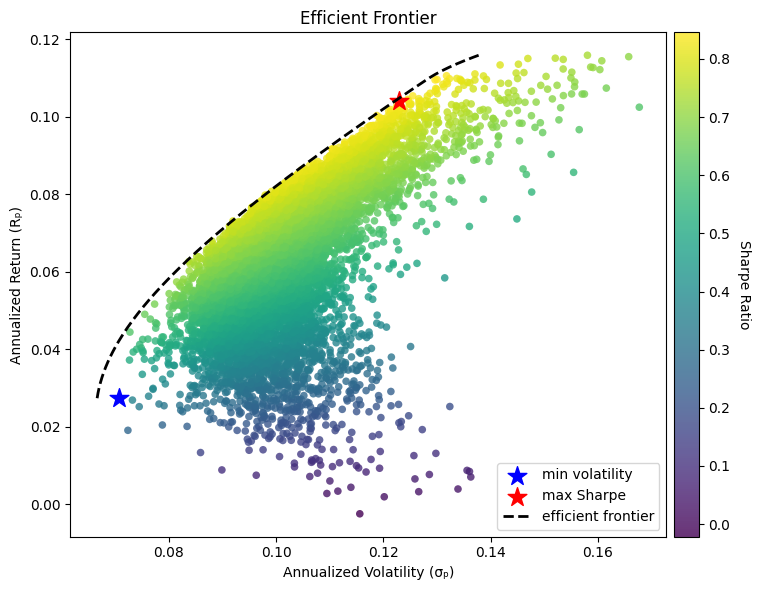

In [103]:
plot_efficient_frontier(sigma_p, R_p, Sharpes, mu, Sigma)

# Backtest: Monthly Rebalancing

In [73]:
from sklearn.covariance import OAS

In [104]:
def portfolio_optimization(mu, Sigma, target=0.08):
    """
    Solve
        minₙ wᵀ Σ w
        s.t.  1ᵀ w = 1, w >= 0, μᵀ w >= target
    """
    n = len(mu)
    w = cp.Variable(n)
    constr = [
        cp.sum(w) == 1,
        w >= 0,
        mu @ w >= target
    ]
    obj  = cp.Minimize(cp.quad_form(w, Sigma))
    prob = cp.Problem(obj, constr)
    prob.solve(solver=cp.OSQP)

    # if infeasible, fall back to uniform weights
    w_val = w.value
    if w_val is None:
        w_val = np.ones(n) / n
    else:
        # clip any tiny negatives & re-normalize
        w_val = np.maximum(w_val, 0)
        w_val /= w_val.sum()

    return w_val

In [114]:
window = 12  # use last 12 months of data to compute mu/sigma
monthly_rets = rets.resample('ME').sum()

dates = monthly_rets.index[window:]  # backtest dates

R_strat = []   # strategy returns
R_naive = []   # equal‐weight returns

for t, date in enumerate(dates, start=window):
    past = monthly_rets.iloc[t-window:t]
    mu    = past.mean(axis=0).values * 12       # annualize
    Sigma = (OAS().fit(past.values).covariance_ * 12)  # annualize
    #Sigma = past.cov().values  * 12       # annualize

    w_star = portfolio_optimization(mu, Sigma, target=0.08)

    # 4) apply to next‐month realized returns
    r_next = monthly_rets.iloc[t].values
    R_strat.append((w_star * r_next).sum())

    # 5) naïve equal‐weight benchmark
    R_naive.append(r_next.mean())

# 6) turn into pandas.Series so we can plot easily
strat_ser = pd.Series(R_strat, index=dates)
naive_ser = pd.Series(R_naive, index=dates)


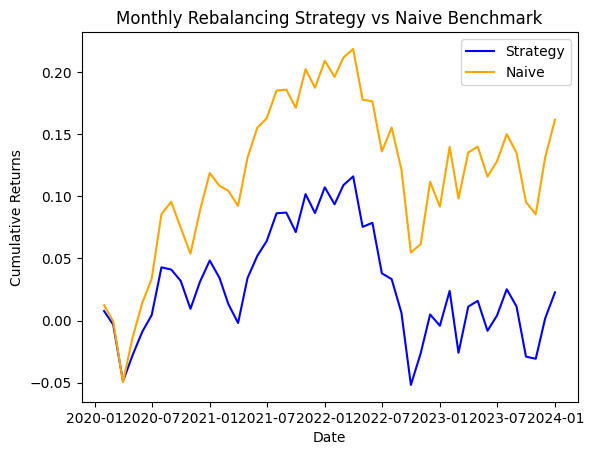

In [115]:
plt.plot(strat_ser.cumsum(), label='Strategy', color='blue')
plt.plot(naive_ser.cumsum(), label='Naive', color='orange')
plt.title('Monthly Rebalancing Strategy vs Naive Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

In [116]:
def calculate_annualized_sharpe(returns):
    """
    Calculate the annualized Sharpe ratio.
    Args:
        returns (np.ndarray): Monthly log-returns of the portfolio
    """
    returns = np.expm1(returns)  # convert log-returns to simple returns
    mean_return = np.mean(returns)
    std_return  = np.std(returns, ddof=0)  # population std
    sharpe_ratio = mean_return / std_return * np.sqrt(12)  # monthly to annual
    return sharpe_ratio

In [117]:
strategy_sharpe = calculate_annualized_sharpe(strat_ser)
naive_sharpe = calculate_annualized_sharpe(naive_ser)

print(f"Strategy Sharpe Ratio: {strategy_sharpe:.2f}")
print(f"Naive Sharpe Ratio: {naive_sharpe:.2f}")

Strategy Sharpe Ratio: 0.11
Naive Sharpe Ratio: 0.46


In [118]:
import seaborn as sns

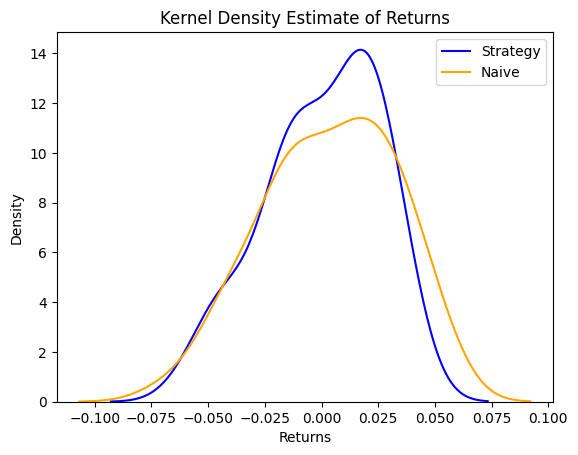

In [119]:
sns.kdeplot(strat_ser, label='Strategy', color='blue')
sns.kdeplot(naive_ser, label='Naive', color='orange')  
plt.title('Kernel Density Estimate of Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend() 

Wilcoxon signed-rank: p=0.016 → returns differ (α=0.05)
Paired t-test: p=0.025 → returns differ (α=0.05)

Annualized Return (Markowitz): 0.57%
Annualized Return (Naïve):     4.12%


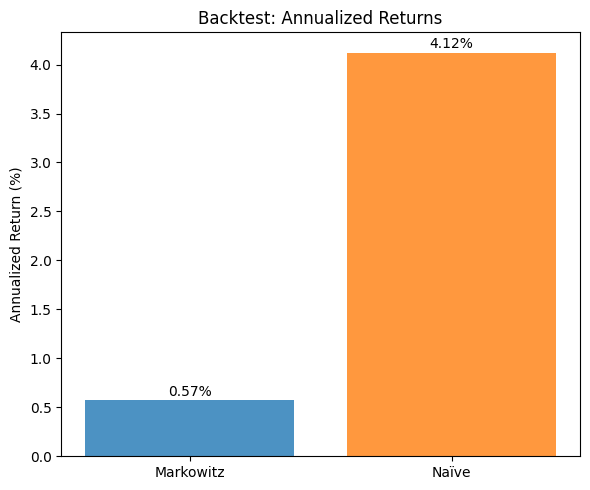

In [135]:

from scipy.stats import wilcoxon, ttest_rel

alpha = 0.05
for name, test in [
    ("Wilcoxon signed-rank", wilcoxon),
    ("Paired t-test",        ttest_rel)
]:
    stat, p = test(strat_ser, naive_ser)
    verdict = "differ" if p < alpha else "do not differ"
    print(f"{name}: p={p:.3f} → returns {verdict} (α={alpha})")

# --- 2) Annualized returns from log‐returns ---
def ann_ret(log_rets, periods_per_year=12):
    mean_log = log_rets.mean()
    annual_log = mean_log * periods_per_year
    return np.expm1(annual_log) * 100    # in percent

ann_strat = ann_ret(strat_ser)
ann_naive = ann_ret(naive_ser)

print(f"\nAnnualized Return (Markowitz): {ann_strat:.2f}%")
print(f"Annualized Return (Naïve):     {ann_naive:.2f}%")

# --- 3) Bar chart ---
fig, ax = plt.subplots(figsize=(6,5))
bars = ax.bar(
    ["Markowitz", "Naïve"],
    [ann_strat, ann_naive],
    color=["C0","C1"],
    alpha=0.8
)
ax.set_ylabel("Annualized Return (%)")
ax.set_title("Backtest: Annualized Returns")

for bar, val in zip(bars, [ann_strat, ann_naive]):
    ax.text(bar.get_x() + bar.get_width()/2, val+.05,
            f"{val:.2f}%", ha='center')

plt.tight_layout()
plt.show()
